In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pingouin as pg 
import seaborn as sns
import csv
import os

In [2]:
data = pd.read_csv('../../../dmri_publication_project/SourceData/rel3_combined_subject_info_and_outcomes.csv', sep='\t', index_col=0)

/volatile/miniconda3/envs/networks/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
### final df 
subjects = pd.read_csv('../../DerivedData/matched_subjects_after_cleaning_incomplete.csv', index_col=0)
#data = pd.read_csv('../../SourceData/release3_subject_info.tsv', sep='\t')
data = pd.read_csv('../../../dmri_publication_project/SourceData/rel3_combined_subject_info_and_outcomes.csv', sep='\t', index_col=0)
data = data[data['session_id '].notna()]
groups = ['FT', 'PT: Ses1', 'PT: Ses2']

new = []
for i, row in subjects.iterrows():
    new.append([row.PT_id, np.int64(row.PT_session1_id), 'PT: Ses1'])
    new.append([row.PT_id, np.int64(row.PT_session2_id), 'PT: Ses2'])
    new.append([row.FT_id, np.int64(row.FT_session_id), 'FT'])
    
new = np.array(new)
d = {'subject_id': new[:,0], 'session_id': new[:, 1], 'group': new[:,2]}
df = pd.DataFrame(data=d)


data.rename(columns={'session_id ': 'session_id',
                     'scan_age ': 'PMA_scan',
                     'birth_age ': 'GA_birth',
                     'sex ': 'sex', 
                     'radiology_score ' : 'radiology_score'
                        }, inplace=True)

data['session_id']=data['session_id'].astype(int)
df['session_id']=df['session_id'].astype(int)

cols = ['session_id', 'PMA_scan', 'GA_birth', 'sex', 'radiology_score'] 
df = pd.merge(df, data[cols], on=['session_id'])

In [4]:
### add flag based on whether subject has fMRI
print('Number of subjects with diffusion data: {}'.format(len(df)/3))

fc = pd.read_pickle('../../DerivedData/matrices/functional/correlation.pickle')

df['has_FC'] = 'No'
df.loc[df.session_id.isin([np.int32(key) for key in fc.keys()]), 'has_FC'] = 'Yes'

Number of subjects with diffusion data: 45.0


### SUBJECT DESCRIPTION

In [5]:
for group in groups: 
    print('Group {}'.format(group))
    sub = df[df.group== group]
    print(len(sub))
        
    print('GA birth: mean (std) {:.1f} ({:.2f}); median [range] {:.1f}, [{:.1f},{:.1f}]'.format( 
                    np.mean(sub.GA_birth.values),  np.std(sub.GA_birth.values), 
                     np.median(sub.GA_birth.values),  np.min(sub.GA_birth.values), np.max(sub.GA_birth.values)       
    ))
    
    print('PMA scan: mean (std) {:.1f} ({:.2f}); median [range] {:.1f}, [{:.1f},{:.1f}]'.format( 
                    np.mean(sub.PMA_scan.values),  np.std(sub.PMA_scan.values), 
                     np.median(sub.PMA_scan.values),  np.min(sub.PMA_scan.values), np.max(sub.PMA_scan.values)       
    ))
    print('Sex: number {} ({:.0f}%) M'.format( 
                    len(sub[sub.sex =='male ']),  len(sub[sub.sex =='male '])*100/len(sub)     
    ))
    
    for score in df.radiology_score.unique():
        print('Radiology Score {}: number {} ({:.0f}%) '.format( score,
                    len(sub[sub.radiology_score ==score]),  len(sub[sub.radiology_score ==score])*100/len(sub)) )

Group FT
45
GA birth: mean (std) 40.3 (1.17); median [range] 40.1, [37.4,42.3]
PMA scan: mean (std) 41.4 (1.41); median [range] 41.3, [38.3,44.7]
Sex: number 26 (58%) M
Radiology Score 3.0: number 5 (11%) 
Radiology Score 1.0: number 29 (64%) 
Radiology Score 2.0: number 11 (24%) 
Group PT: Ses1
45
GA birth: mean (std) 31.8 (2.84); median [range] 32.3, [25.6,36.0]
PMA scan: mean (std) 34.1 (1.88); median [range] 34.9, [28.3,36.9]
Sex: number 26 (58%) M
Radiology Score 3.0: number 8 (18%) 
Radiology Score 1.0: number 27 (60%) 
Radiology Score 2.0: number 10 (22%) 
Group PT: Ses2
45
GA birth: mean (std) 31.8 (2.84); median [range] 32.3, [25.6,36.0]
PMA scan: mean (std) 41.4 (1.42); median [range] 41.3, [38.4,44.9]
Sex: number 26 (58%) M
Radiology Score 3.0: number 13 (29%) 
Radiology Score 1.0: number 19 (42%) 
Radiology Score 2.0: number 13 (29%) 


In [6]:
# delays between birth and scan 
for group in groups: 
    print('Group {}'.format(group))
    sub = df[df.group== group]
    print(len(sub))
    
    birth = sub.GA_birth.values
    scan = sub.PMA_scan.values
    delay = scan - birth
        
    print('Delay: mean (std) {:.1f} ({:.2f}); median [range] {:.1f}, [{:.1f},{:.1f}]'.format( 
                    np.mean(delay),  np.std(delay), 
                     np.median(delay),  np.min(delay), np.max(delay)       
    ))


Group FT
45
Delay: mean (std) 1.1 (1.16); median [range] 0.4, [0.1,3.9]
Group PT: Ses1
45
Delay: mean (std) 2.3 (1.97); median [range] 1.7, [0.1,9.3]
Group PT: Ses2
45
Delay: mean (std) 9.6 (3.07); median [range] 9.1, [3.6,15.6]


In [7]:
groups

['FT', 'PT: Ses1', 'PT: Ses2']

In [8]:
# delays between ses1 and ses2 


s2 = df[df.group== 'PT: Ses2'].PMA_scan.values
s1 = df[df.group== 'PT: Ses1'].PMA_scan.values

delay = s2 - s1
        
print('Delay: mean (std) {:.1f} ({:.2f}); median [range] {:.1f}, [{:.1f},{:.1f}]'.format( 
                    np.mean(delay),  np.std(delay), 
                     np.median(delay),  np.min(delay), np.max(delay)   ))


Delay: mean (std) 7.3 (2.14); median [range] 7.3, [2.7,11.9]


In [9]:
_,_,res = pg.chi2_independence(df, x='group', y='radiology_score' )
print('IMDQuintile (at lambda=1) p-val=', res[res.test=='pearson']['pval'].values[0])

IMDQuintile (at lambda=1) p-val= 0.1698368736454184


In [10]:
pg.corr(s2,s1)

,n,r,CI95%,p-val,BF10,power
pearson,45,0.184092,"[-0.12, 0.45]",0.226067,0.378,0.229594


## Plotting ages and scores

/tmp/ipykernel_18845/2825298732.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.ax_joint.set_yticklabels(np.int64(g.ax_joint.get_yticks()), size = 14)
/tmp/ipykernel_18845/2825298732.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.ax_joint.set_xticklabels(np.int64(g.ax_joint.get_xticks()), size = 14)
/tmp/ipykernel_18845/2825298732.py:29: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.savefig('../../Results/GC_FC_paper/figures/001_jointplot_GA_PMA_across_groups.jpg', dpi=300,  bbox_inches='tight')


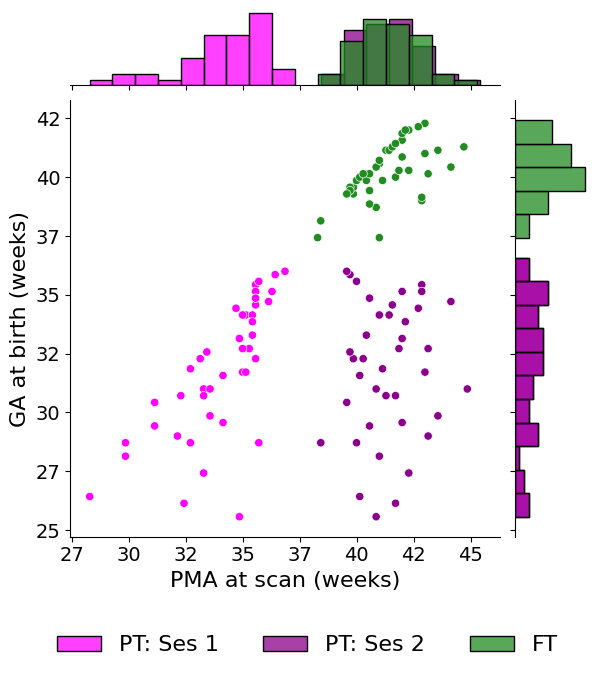

In [47]:
a =df.copy()

grid = sns.JointGrid(x='PMA_scan', y='GA_birth', data=a )
g = grid.plot_joint(sns.scatterplot, hue='group', data=a, palette={
                            'PT: Ses1': 'magenta',
                            'PT: Ses2': 'darkmagenta', 
                             'FT': 'forestgreen'}, legend=False)
sns.histplot(a.loc[a['group']=='PT: Ses1', 'PMA_scan'], ax=g.ax_marg_x, legend=False, color='magenta', binwidth=1)
sns.histplot(a.loc[a['group']=='PT: Ses2', 'PMA_scan'], ax=g.ax_marg_x, legend=False, color='darkmagenta', binwidth=1)
sns.histplot(a.loc[a['group']=='FT', 'PMA_scan'], ax=g.ax_marg_x, legend=False, color='forestgreen', binwidth=1)

sns.histplot(y=a.loc[a['group']=='PT: Ses1', 'GA_birth'], ax=g.ax_marg_y, legend=False, color='magenta', binwidth=1)
sns.histplot(y=a.loc[a['group']=='PT: Ses2', 'GA_birth'], ax=g.ax_marg_y, legend=False, color='darkmagenta', binwidth=1)
sns.histplot(y=a.loc[a['group']=='FT', 'GA_birth'], ax=g.ax_marg_y, legend=False, color='forestgreen', binwidth=1)

plt.legend(labels= ['PT: Ses 1', 'PT: Ses 2', 'FT'],
    loc= "upper center", ncol = 3, bbox_to_anchor=(-2.8, -0.18),  fontsize=16, frameon=False)

g.ax_joint.set_xlabel('PMA at scan (weeks)', fontsize=16)
g.ax_joint.set_ylabel('GA at birth (weeks)', fontsize=16)

g.ax_joint.set_yticklabels(np.int64(g.ax_joint.get_yticks()), size = 14)
g.ax_joint.set_xticklabels(np.int64(g.ax_joint.get_xticks()), size = 14)
g.fig.set_tight_layout(tight=4)
g.fig.patch.set_facecolor('white')

plt.savefig('../../Results/GC_FC_paper/figures/001_jointplot_GA_PMA_across_groups.jpg', dpi=300,  bbox_inches='tight') 
plt.show()

### plotting the relationships between scan delay and ages 

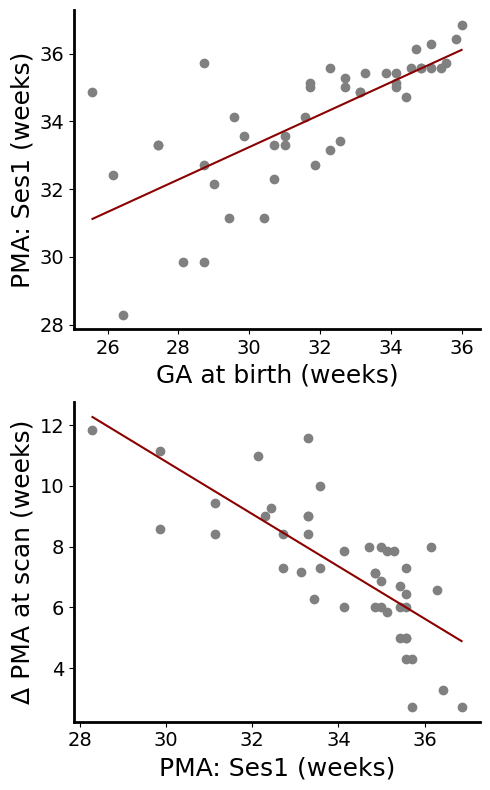

In [72]:
fig, axs = plt.subplots(2,1, figsize=(5,8))

long_subjects = a[a.group == 'PT: Ses1']['subject_id'].values
ages_birth = [a.loc[(a.subject_id == subject) & (a.group == 'PT: Ses1')]['GA_birth'].values[0] for subject in long_subjects]
ages_1st_scan = [a.loc[(a.subject_id == subject) & (a.group == 'PT: Ses1')]['PMA_scan'].values[0] for subject in long_subjects]

lr = pg.linear_regression( ages_birth,ages_1st_scan,)   

#fig, ax = plt.subplots(1,1)
ind = np.argsort(np.array(ages_birth))
m, b = np.polyfit(np.float32(np.array(ages_birth)[ind]), np.float32(np.array(ages_1st_scan)[ind]), 1)
axs[0].plot(np.array(ages_birth)[ind], m* np.array(ages_birth)[ind] + b, c = 'darkred')    
axs[0].scatter(ages_birth,ages_1st_scan, c='gray')
axs[0].set_ylabel('PMA: Ses1 (weeks)', fontsize=18)
axs[0].set_xlabel('GA at birth (weeks)', fontsize=18)
#axs[0].set_title('Scan delay Ses1:Ses2', fontsize=20)

d_list = []
ga_list = []

for subject in long_subjects:
    PMA_s1 = a.loc[(a.subject_id == subject) & (a.group == 'PT: Ses1')]['PMA_scan'].values[0]
    PMA_s2 = a.loc[(a.subject_id == subject) & (a.group == 'PT: Ses2')]['PMA_scan'].values[0]
    d_list.append(PMA_s2 - PMA_s1)
    ga_list.append( a.loc[(a.subject_id == subject) & (a.group == 'PT: Ses1')]['PMA_scan'].values[0])

lr = pg.linear_regression(d_list, ga_list)   

ind = np.argsort(np.array(ga_list))
m, b = np.polyfit(np.float32(np.array(ga_list)[ind]), np.float32(np.array(d_list)[ind]), 1)
axs[1].plot(np.array(ga_list)[ind], m* np.array(ga_list)[ind] + b, c = 'darkred')    
axs[1].scatter(ga_list, d_list, c='gray')
axs[1].set_ylabel('\u0394 PMA at scan (weeks)', fontsize=18)
axs[1].set_xlabel('PMA: Ses1 (weeks)', fontsize=18)
#axs[1].set_title('Scan delay Ses1:Ses2', fontsize=20)

# Make prettier
for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(2)
    ax.tick_params(axis='y', labelsize=14) 
    ax.tick_params(axis='x', labelsize=14)


plt.tight_layout()
fig.savefig('../../Results/GC_FC_paper/figures/002_scan_delay.png', dpi=300)
plt.show()


### plotting dMRI & fMRI QC

fMRI: 
* best:  CC00135AN12, 44900,  PT: Ses1, PMA scan: 35.14, GA birth: 35.14
* worst: CC00653XX10, 191801 FT, PMA scan: 39.71, GA birth: 39.571429

In [73]:
### final df 
subjects = pd.read_csv('../../DerivedData/matched_subjects_after_cleaning_incomplete.csv', index_col=0)
#data = pd.read_csv('../../SourceData/release3_subject_info.tsv', sep='\t')
data = pd.read_csv('../../../dmri_publication_project/SourceData/rel3_combined_subject_info_and_outcomes.csv', sep='\t', index_col=0)
data = data[data['session_id '].notna()]
groups = ['FT', 'PT: Ses1', 'PT: Ses2']

new = []
for i, row in subjects.iterrows():
    new.append([row.PT_id, np.int64(row.PT_session1_id), 'PT: Ses1'])
    new.append([row.PT_id, np.int64(row.PT_session2_id), 'PT: Ses2'])
    new.append([row.FT_id, np.int64(row.FT_session_id), 'FT'])
    
new = np.array(new)
d = {'subject_id': new[:,0], 'session_id': new[:, 1], 'group': new[:,2]}
df = pd.DataFrame(data=d)


data.rename(columns={'session_id ': 'session_id',
                     'scan_age ': 'PMA_scan',
                     'birth_age ': 'GA_birth', 
                     'sex ': 'sex'
                        }, inplace=True)

data['session_id']=data['session_id'].astype(int)
df['session_id']=df['session_id'].astype(int)

cols = ['session_id', 'PMA_scan', 'GA_birth', 'sex', 
       'qc_dmri_shard_translation ', 'qc_dmri_shard_rotation ','qc_dmri_shard_outlier_ratio ', 'qc_dmri_shard_snr ', 
       'qc_fmri_dvars_z ', 'qc_fmri_tsnr_z ',
       'qc_fmri_mcdc2sbref_z ', 'qc_fmri_sbref2struct_z ',
       'qc_fmri_fmap2struct_z ', 'qc_fmri_standard2struct_z ',
       'qc_fmri_flagged ', 'qc_fmri_comment ',] 
df = pd.merge(df, data[cols], on=['session_id'])


/tmp/ipykernel_18845/3226783418.py:18: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(qc.loc[qc['group']=='PT: Ses1', 'qc_dmri_shard_rotation '], ax=g.ax_marg_y, vertical=True, legend=False, color='magenta')
/tmp/ipykernel_18845/3226783418.py:19: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(qc.loc[qc['group']=='PT: Ses2', 'qc_dmri_shard_rotation '], ax=g.ax_marg_y, vertical=True,  legend=False, color='darkmagenta')
/tmp/ipykernel_18845/3226783418.py:20: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(qc.loc[qc['group']=='FT', 'qc_dmri_shard_rotation '], ax=g.ax_marg_y,vertical=True,  legend=False, color='forestgreen')
/tmp/ipykernel_18845/3

<Figure size 640x480 with 0 Axes>

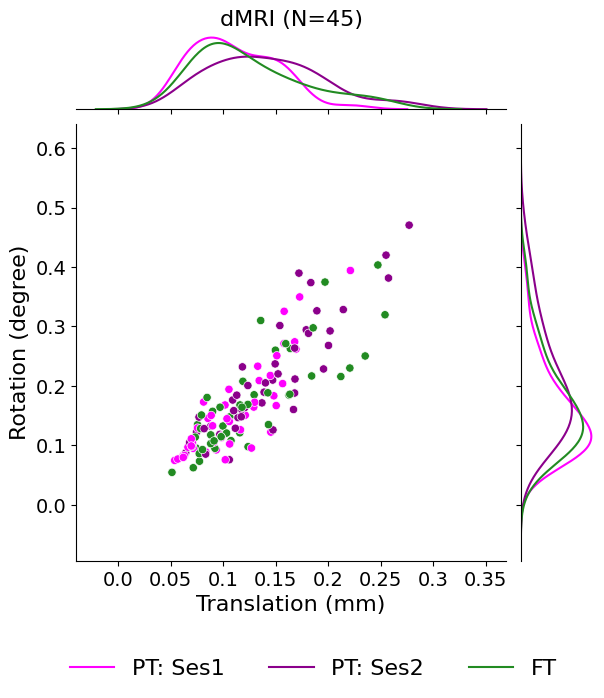

In [77]:
### dmri
#qc = df[df['session_id'].isin(ids)]
qc = df.copy()

fig = plt.figure()
grid = sns.JointGrid(x='qc_dmri_shard_translation ', y='qc_dmri_shard_rotation ', data=qc, 
                    )

g = grid.plot_joint(sns.scatterplot, hue='group', data=qc, palette={
                            'PT: Ses1': 'magenta',
                            'PT: Ses2': 'darkmagenta', 
                             'FT': 'forestgreen'}, legend=False)

sns.kdeplot(qc.loc[qc['group']=='PT: Ses1', 'qc_dmri_shard_translation '], ax=g.ax_marg_x, legend=False, color='magenta')
sns.kdeplot(qc.loc[qc['group']=='PT: Ses2', 'qc_dmri_shard_translation '], ax=g.ax_marg_x, legend=False, color='darkmagenta')
sns.kdeplot(qc.loc[qc['group']=='FT', 'qc_dmri_shard_translation '], ax=g.ax_marg_x, legend=False, color='forestgreen')

sns.kdeplot(qc.loc[qc['group']=='PT: Ses1', 'qc_dmri_shard_rotation '], ax=g.ax_marg_y, vertical=True, legend=False, color='magenta')
sns.kdeplot(qc.loc[qc['group']=='PT: Ses2', 'qc_dmri_shard_rotation '], ax=g.ax_marg_y, vertical=True,  legend=False, color='darkmagenta')
sns.kdeplot(qc.loc[qc['group']=='FT', 'qc_dmri_shard_rotation '], ax=g.ax_marg_y,vertical=True,  legend=False, color='forestgreen')

plt.legend(labels= ['PT: Ses1', 'PT: Ses2', 'FT'],
    loc= "upper center", ncol = 3, bbox_to_anchor=(-2.8, -0.18),  fontsize=16, frameon=False)

g.ax_joint.set_xlabel('Translation (mm)', fontsize=16)
g.ax_joint.set_ylabel('Rotation (degree)', fontsize=16)

g.ax_joint.set_yticklabels(np.round(g.ax_joint.get_yticks(),2), size = 14)
g.ax_joint.set_xticklabels(np.round(g.ax_joint.get_xticks(),2), size = 14)
g.fig.set_tight_layout(tight=4)

g.ax_marg_x.set_title('dMRI (N={})'.format(len(qc[qc['group']=='PT: Ses1'])), fontsize=16)

fig.patch.set_facecolor('white')
plt.savefig('../../Results/GC_FC_paper/figures/dMRI_QC.jpg', dpi=300,  bbox_inches='tight') 
plt.show()

/tmp/ipykernel_18845/3784967062.py:19: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(qc.loc[qc['group']=='PT: Ses1', 'qc_fmri_tsnr_z '], ax=g.ax_marg_y, vertical=True, legend=False, color='magenta')
/tmp/ipykernel_18845/3784967062.py:20: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(qc.loc[qc['group']=='PT: Ses2', 'qc_fmri_tsnr_z '], ax=g.ax_marg_y, vertical=True,  legend=False, color='darkmagenta')
/tmp/ipykernel_18845/3784967062.py:21: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(qc.loc[qc['group']=='FT', 'qc_fmri_tsnr_z '], ax=g.ax_marg_y,vertical=True,  legend=False, color='forestgreen')
/tmp/ipykernel_18845/3784967062.py:29: UserWar

<Figure size 640x480 with 0 Axes>

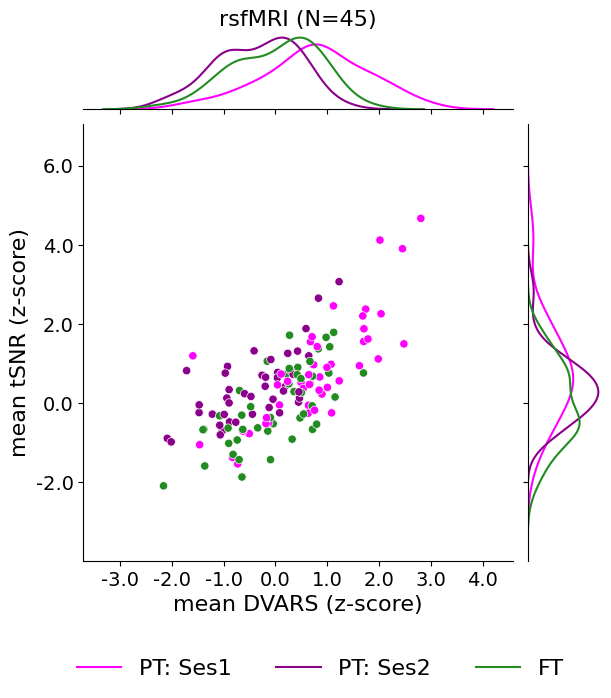

In [79]:
## rsfMRI
#qc = df[df['session_id'].isin(ids)]
#qc = fmri_df.copy()
qc = df.copy()

fig = plt.figure()
grid = sns.JointGrid(x='qc_fmri_dvars_z ', y='qc_fmri_tsnr_z ', data=qc, 
                    )

g = grid.plot_joint(sns.scatterplot, hue='group', data=qc, palette={
                            'PT: Ses1': 'magenta',
                            'PT: Ses2': 'darkmagenta', 
                             'FT': 'forestgreen'}, legend=False)

sns.kdeplot(qc.loc[qc['group']=='PT: Ses1', 'qc_fmri_dvars_z '], ax=g.ax_marg_x, legend=False, color='magenta')
sns.kdeplot(qc.loc[qc['group']=='PT: Ses2', 'qc_fmri_dvars_z '], ax=g.ax_marg_x, legend=False, color='darkmagenta')
sns.kdeplot(qc.loc[qc['group']=='FT', 'qc_fmri_dvars_z '], ax=g.ax_marg_x, legend=False, color='forestgreen')

sns.kdeplot(qc.loc[qc['group']=='PT: Ses1', 'qc_fmri_tsnr_z '], ax=g.ax_marg_y, vertical=True, legend=False, color='magenta')
sns.kdeplot(qc.loc[qc['group']=='PT: Ses2', 'qc_fmri_tsnr_z '], ax=g.ax_marg_y, vertical=True,  legend=False, color='darkmagenta')
sns.kdeplot(qc.loc[qc['group']=='FT', 'qc_fmri_tsnr_z '], ax=g.ax_marg_y,vertical=True,  legend=False, color='forestgreen')

plt.legend(labels= ['PT: Ses1', 'PT: Ses2', 'FT'],
    loc= "upper center", ncol = 3, bbox_to_anchor=(-2.8, -0.18),  fontsize=16, frameon=False)

g.ax_joint.set_xlabel('mean DVARS (z-score)', fontsize=16)
g.ax_joint.set_ylabel('mean tSNR (z-score)', fontsize=16)

g.ax_joint.set_yticklabels(np.round(g.ax_joint.get_yticks(),2), size = 14)
g.ax_joint.set_xticklabels(np.round(g.ax_joint.get_xticks(),2), size = 14)
g.fig.set_tight_layout(tight=4)

g.ax_marg_x.set_title('rsfMRI (N={})'.format(len(qc[qc['group']=='PT: Ses1'])), fontsize=16)

fig.patch.set_facecolor('white')
plt.savefig('../../Results/GC_FC_paper/figures/fMRI_QC.jpg', dpi=300,  bbox_inches='tight') 
plt.show()

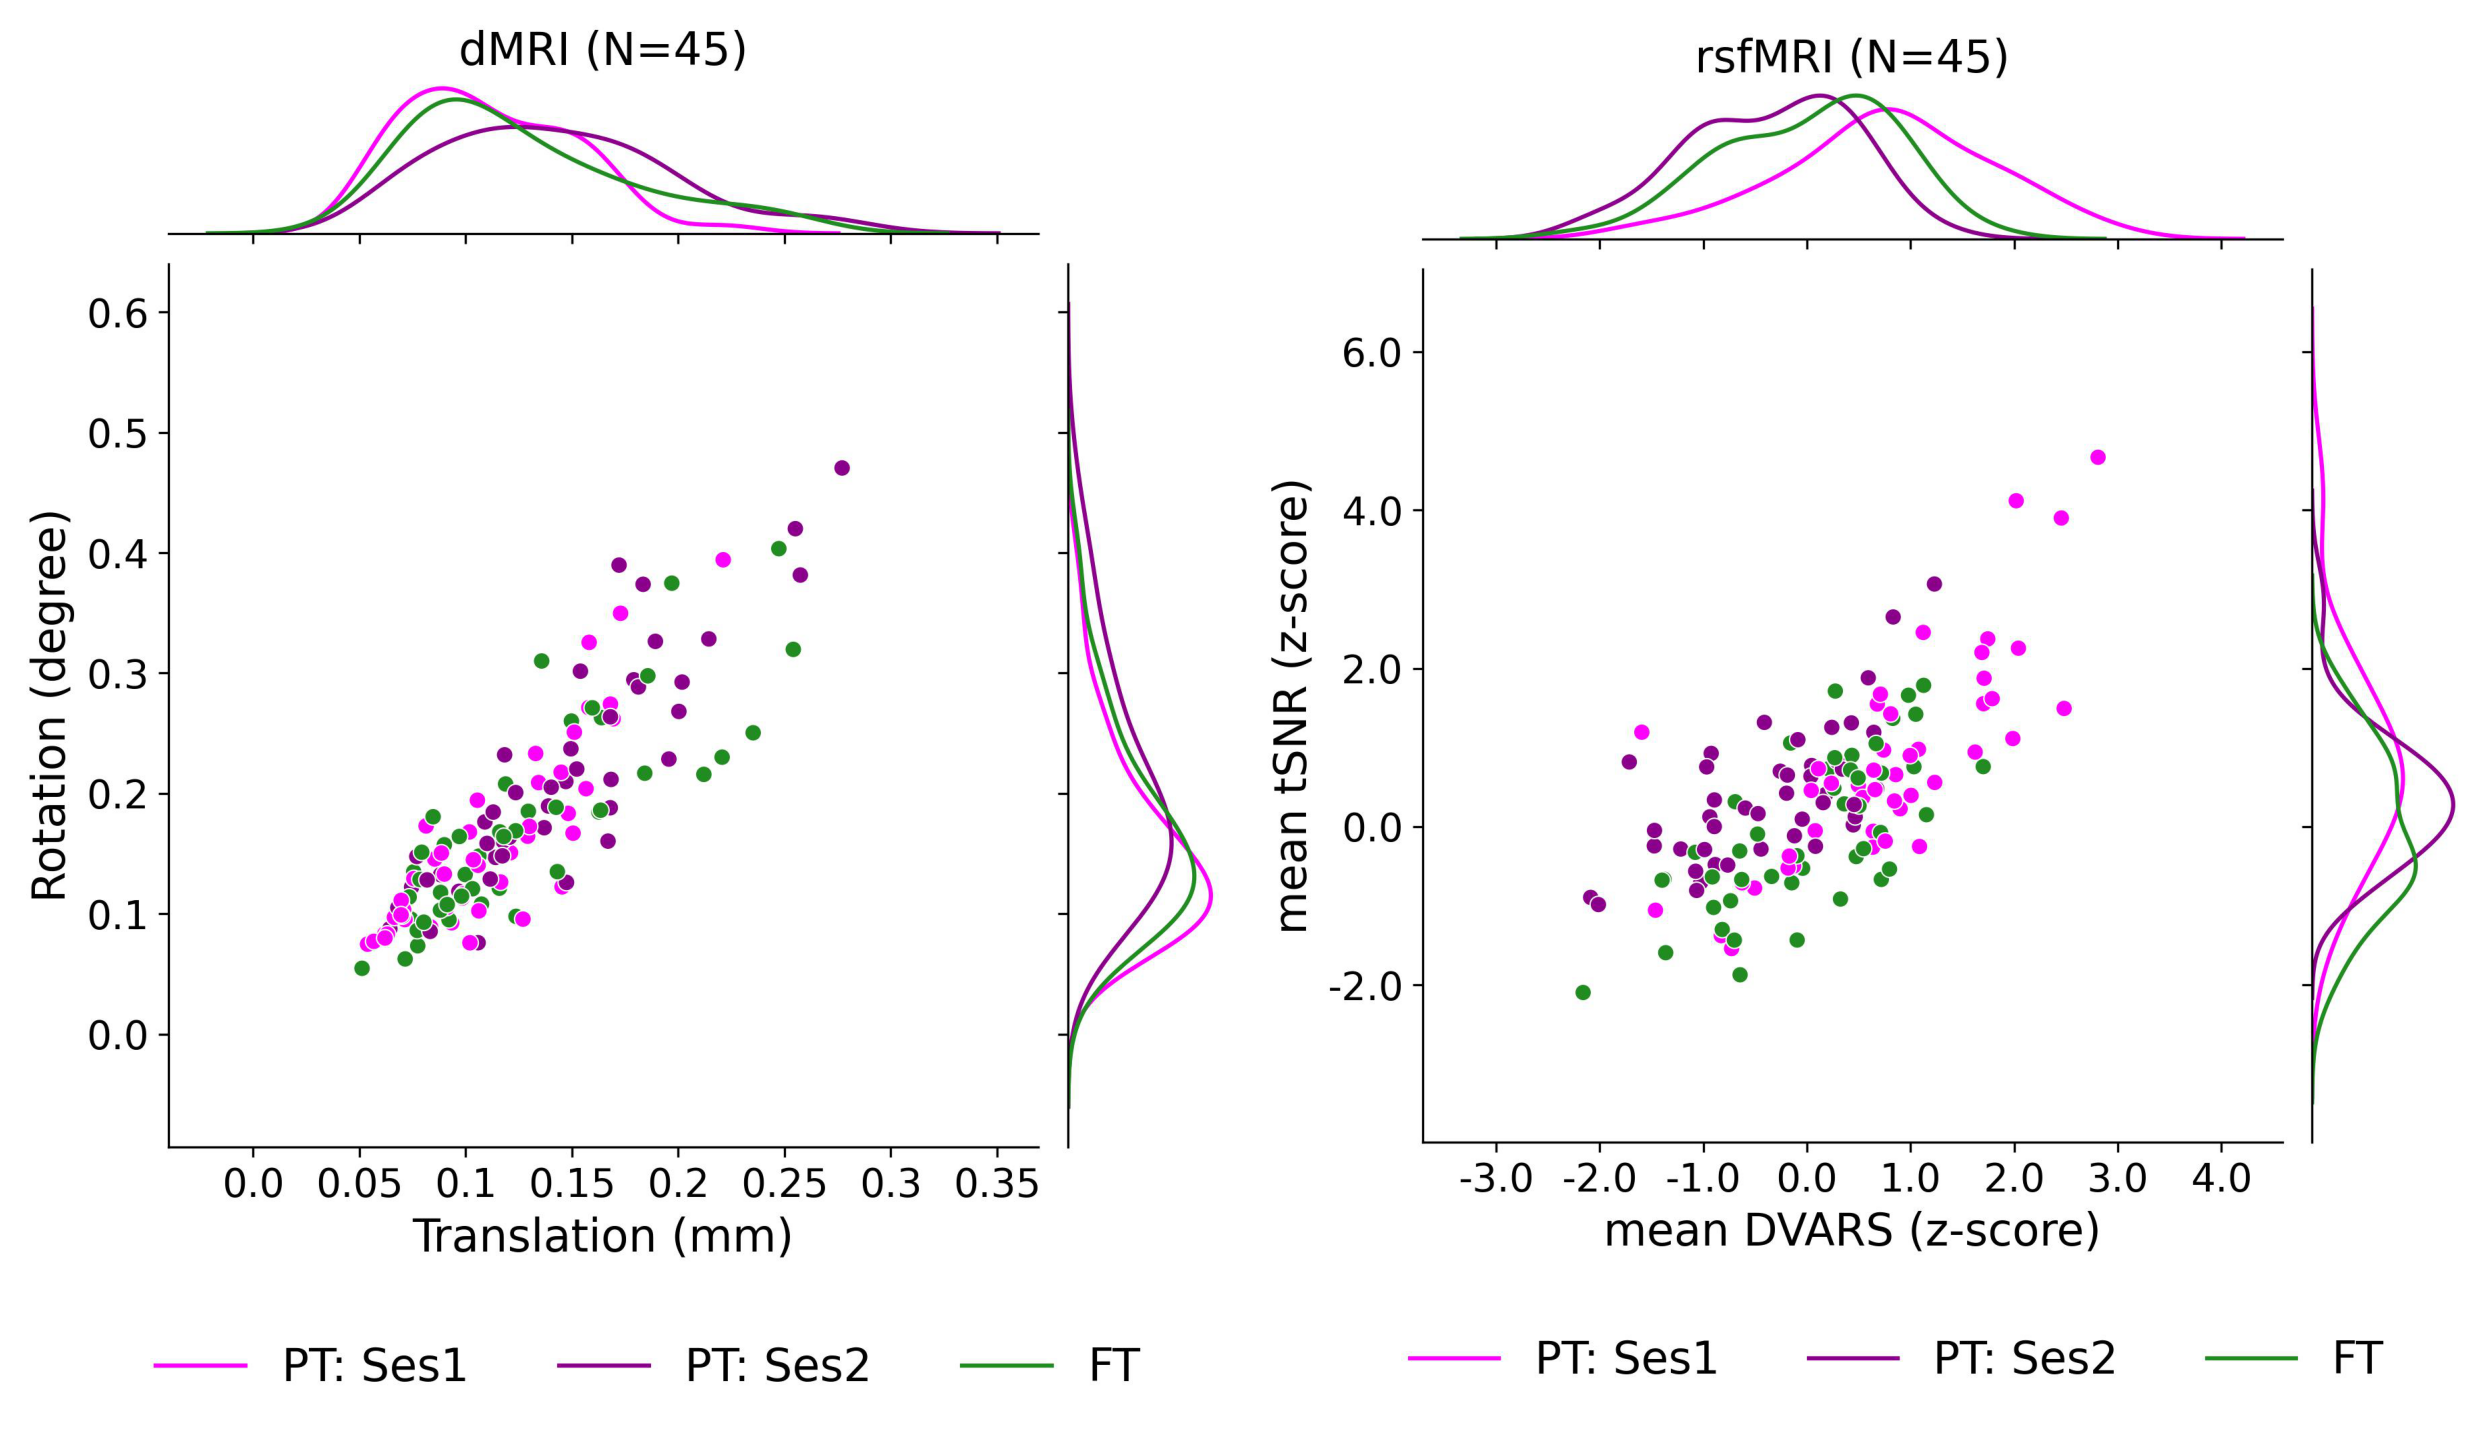

In [81]:
# combine
fig = plt.figure(figsize=(25, 25))
ax = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(ax[0, 0])

ax1.imshow(mpimg.imread('../../Results/GC_FC_paper/figures/dMRI_QC.jpg'))
ax1.set_axis_off()
ax1 = fig.add_subplot(ax[0, 1])
ax1.imshow(mpimg.imread('../../Results/GC_FC_paper/figures/fMRI_QC.jpg'))
ax1.set_axis_off()
plt.tight_layout()
plt.savefig('../../Results/GC_FC_paper/figures/003_combined_modalities_QC.jpg', dpi=300,  bbox_inches='tight') 
plt.show()

In [6]:
## median worst and best subject
subj = {
    'worst': ['CC00653XX10', 191801],
    'best': ['CC00135AN12',44900 ]
}


In [7]:
from nilearn.image import load_img
import nibabel as nib

In [20]:
for subject in ['best', 'worst']:
    iData = '../functional/rel3_dhcp_fmri_pipeline/sub-{}/ses-{}/func/sub-{}_ses-{}_task-rest_desc-preproc_bold.nii.gz'.format(
                subj[subject][0], subj[subject][1], subj[subject][0], subj[subject][1]
                        )
    
    fmri = load_img(iData)
    ar = np.asanyarray(fmri.dataobj)
    b = np.median(ar, axis=3)
    print('Saving {}'.format(subject))
    img = nib.Nifti1Image(b, np.eye(4))
    nib.save(img, '../../Results/GC_FC_paper/{}_{}_{}_median_fMRI.nii.gz'.format(subj[subject][0], subj[subject][1], subject)) 
    

Saving best
Saving worst
